In [22]:
import pandas as pd
import sklearn
from sklearn.linear_model import LinearRegression
import numpy as np
from pandas_summary import DataFrameSummary
import pandas_profiling as pp
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegressionCV, LogisticRegression
from sklearn import preprocessing
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
import random
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
import plotly.graph_objs as go
from plotly.offline import iplot, init_notebook_mode
init_notebook_mode(connected=True)
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score
import xgboost as xgb
import graphviz 
from sklearn.neural_network import MLPClassifier
from sklearn import tree
from pandas.util import hash_pandas_object
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import fbeta_score, make_scorer
from sklearn.model_selection import RepeatedKFold, RepeatedStratifiedKFold, StratifiedKFold, cross_val_score
import imblearn
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline
%matplotlib inline
from IPython.core.debugger import set_trace
from dateutil.parser import parse
from collections import defaultdict

In [2]:
import os
# os.getcwd()
train_set_df_orig = pd.read_csv("port_visits_train.csv", parse_dates = ['start_time'], date_parser = parse )
train_vessels_labels_orig = pd.read_csv("vessels_labels_train.csv", index_col='vessel_id' )

# test_set_df = pd.read_csv("test_set.csv", parse_dates = ['timestamp'], date_parser = parse )

In [11]:
train_set_df_orig

,ves_id,start_time,duration_min,port_id,country,Lat,Long,port_name
0,56db7bf5e4b087b8d90a9d5e,2016-03-10 07:55:05,1641,57ce88b62e4e5fe35e7b3008,Indonesia,1.042,103.325,PT
1,56d88f20e4b0e60539c699ca,2016-03-31 07:37:35,730,5358fc78b68ca120a07dbca5,China,34.664,119.519,Lianyungang
2,56d96b7be4b0cdbda2acd645,2016-06-16 07:24:58,141,5358fc78b68ca120a07dbb33,Netherlands,51.689,4.590,Moerdijk
3,56d88f20e4b0e60539c699ca,2016-03-10 05:28:48,931,53720b4f57b2d3980edf9bfa,China,36.016,120.233,Qingdao
4,56d835ace4b09b379252ab21,2016-04-26 18:12:19,1,5358fc77b68ca120a07db099,France,47.276,-1.885,Cordemais
...,...,...,...,...,...,...,...,...
732479,56d88f20e4b0e60539c699ca,2016-03-20 23:59:11,10516,53749f7d8925ee691cb9b4ea,China,31.363,121.714,Chanxingdao
732480,56d96d97e4b0d1ae1fbebd6b,2016-06-13 06:10:45,1625,562cc82a8c0e57be50751ec1,India,18.958,72.941,Jawaharlal Nehru - Nhava Sheva
732481,56d9026ce4b0b5eaae32988f,2016-03-16 08:56:22,0,5358fc78b68ca120a07db709,Denmark,55.944,11.767,Rorvig Havn
732482,56d9026ce4b0b5eaae32988f,2016-03-16 09:32:12,29,5358fc77b68ca120a07db26a,Denmark,55.962,11.847,Hundested Havn


In [14]:
train_set_df_orig.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 732484 entries, 0 to 732483
Data columns (total 8 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   ves_id        732484 non-null  object        
 1   start_time    732484 non-null  datetime64[ns]
 2   duration_min  732484 non-null  int64         
 3   port_id       732484 non-null  object        
 4   country       732171 non-null  object        
 5   Lat           732484 non-null  float64       
 6   Long          732484 non-null  float64       
 7   port_name     732444 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 44.7+ MB


In [40]:
train_vessels_labels_orig

,type,label
vessel_id,,
56d8509fe4b099a29d073a62,Container Vessel,0
56d950d9e4b0e60539c6b71d,Container Vessel,0
56d85a07e4b0fb60063969d8,Bulk Carrier,0
56d85736e4b030f1c0039905,Oil Tanker,1
56db31f9e4b02c227b748c14,Tug,0
...,...,...
56d83d91e4b0370600ea6b14,Fishing Vessel,0
56d98b06e4b036f77e70799a,Tug,0
56d8348ee4b026569c5ac90f,Oil Tanker,1


In [19]:
train_set_df_orig['type'] = train_set_df_orig['ves_id'].apply(lambda vid : 
                                    train_vessels_labels_orig.loc[vid, 'type'])
train_set_df_orig['label'] = train_set_df_orig['ves_id'].apply(lambda vid : 
                                    train_vessels_labels_orig.loc[vid, 'label'])

In [20]:
train_set_df_orig

,ves_id,start_time,duration_min,port_id,country,Lat,Long,port_name,label,type
0,56db7bf5e4b087b8d90a9d5e,2016-03-10 07:55:05,1641,57ce88b62e4e5fe35e7b3008,Indonesia,1.042,103.325,PT,0,Tug
1,56d88f20e4b0e60539c699ca,2016-03-31 07:37:35,730,5358fc78b68ca120a07dbca5,China,34.664,119.519,Lianyungang,0,Container Vessel
2,56d96b7be4b0cdbda2acd645,2016-06-16 07:24:58,141,5358fc78b68ca120a07dbb33,Netherlands,51.689,4.590,Moerdijk,0,Tug
3,56d88f20e4b0e60539c699ca,2016-03-10 05:28:48,931,53720b4f57b2d3980edf9bfa,China,36.016,120.233,Qingdao,0,Container Vessel
4,56d835ace4b09b379252ab21,2016-04-26 18:12:19,1,5358fc77b68ca120a07db099,France,47.276,-1.885,Cordemais,0,Bulk Carrier
...,...,...,...,...,...,...,...,...,...,...
732479,56d88f20e4b0e60539c699ca,2016-03-20 23:59:11,10516,53749f7d8925ee691cb9b4ea,China,31.363,121.714,Chanxingdao,0,Container Vessel
732480,56d96d97e4b0d1ae1fbebd6b,2016-06-13 06:10:45,1625,562cc82a8c0e57be50751ec1,India,18.958,72.941,Jawaharlal Nehru - Nhava Sheva,0,Container Vessel
732481,56d9026ce4b0b5eaae32988f,2016-03-16 08:56:22,0,5358fc78b68ca120a07db709,Denmark,55.944,11.767,Rorvig Havn,0,Passenger Vessel
732482,56d9026ce4b0b5eaae32988f,2016-03-16 09:32:12,29,5358fc77b68ca120a07db26a,Denmark,55.962,11.847,Hundested Havn,0,Passenger Vessel


In [21]:
train_set_df_orig[train_set_df_orig['ves_id'] == '56d8348ae4b02a0dec522fd6']

,ves_id,start_time,duration_min,port_id,country,Lat,Long,port_name,label,type
52633,56d8348ae4b02a0dec522fd6,2016-01-13 12:13:10,2068,551400d4001ecfd14d4af881,SaudiArabia,26.937,50.054,Ju'aymah Crude and LPG Terminals,1,Oil Tanker
52634,56d8348ae4b02a0dec522fd6,2016-03-23 05:58:37,0,5523b39459de2ed24dc2be6b,Venezuela,10.138,-64.828,Jose Petroterminal TAECJ,1,Oil Tanker
216107,56d8348ae4b02a0dec522fd6,2016-04-30 11:18:29,3945,5358fc78b68ca120a07dbd17,India,22.483,69.676,Vadinar,1,Oil Tanker
398599,56d8348ae4b02a0dec522fd6,2016-05-16 09:09:45,1179,551400d4001ecfd14d4af881,SaudiArabia,26.937,50.054,Ju'aymah Crude and LPG Terminals,1,Oil Tanker
398600,56d8348ae4b02a0dec522fd6,2016-05-13 20:59:29,2112,553ca9a5d4e6a49b3fb0d1e0,Kuwait,29.136,48.303,Mina Al Ahmadi,1,Oil Tanker


# EDA

## Initial examination of the raw data ##

**Unique vessels**

In [26]:
uniqe_ves_ids_train_orig = np.unique(train_set_df_orig.ves_id)
len(uniqe_ves_ids_train_orig)

21122

In [27]:
len(train_vessels_labels_orig)

21642

In [29]:
labels_vess_ids_intersect = set(uniqe_ves_ids_train_orig).intersection(train_vessels_labels_orig.vessel_id)
labels_vess_ids_diff = set(train_vessels_labels_orig.vessel_id ).difference(uniqe_ves_ids_train_orig)
print(f"There are {len(labels_vess_ids_intersect)} vess_ids appearing both in the train df and lables df")
print(f"There are {len(labels_vess_ids_diff)} vess_ids appearing in the lables df but not in the labels_vess_ids_diff")

There are 21122 vess_ids appearing both in the train df and lables df
There are 520 vess_ids appearing in the lables df but not in the labels_vess_ids_diff


**Unique ports**

In [5]:
num_unique_ports_in_train = len(np.unique(train_set_df_orig.port_id.dropna()))
print(f"there are {num_unique_ports_in_train} unique ports in the train set")

there are 3590 unique ports in the train set


**The distribution of the labels is around 13.7% 1 (Tanker) and 86.3% 0 (not a tanker)**

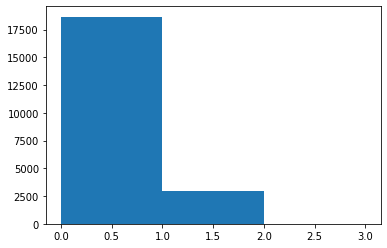

In [30]:
y_train_raw = train_vessels_labels_orig.label
counts = plt.hist(y_train_raw, bins =  [0,1,2,3] )

In [31]:
counts[0]/counts[0].sum()*100

array([86.22585713, 13.77414287,  0.        ])

In [ ]:
train_vessels_labels_orig
counts = plt.hist(y_train_raw, bins =  [0,1,2,3] )

## Duration distribution as a function of the vessel type ##

**What's the subset of ports visited by tankers**

In [6]:
tankers_ports_set = set(train_set_df_orig['port_id'][train_set_df_orig['label']==1])
print("There are {} ports visited by tankers, which are\
 {:0.2f}% of the overall ports".format(len(tankers_ports_set), len(tankers_ports_set)/num_unique_ports_in_train*100))

There are 1652 ports visited by tankers, which are 46.02% of the overall ports


In [9]:
all_ports_set = set(np.unique(train_set_df_orig.port_id.dropna()))
non_tanker_ports_set = set(train_set_df_orig['port_id'][train_set_df_orig['label']==0])
print("The intersection between the tankers ports and non-tanker ports is of size {} ".format(len(non_tanker_ports_set.intersection(tankers_ports_set))))

The intersection between the tankers ports and non-tanker ports is of size 1520 


**Durations distribution per port**

There were 3 tankers visits and 22 non-tanker visits to port 57b42870c94a74d24170f1af


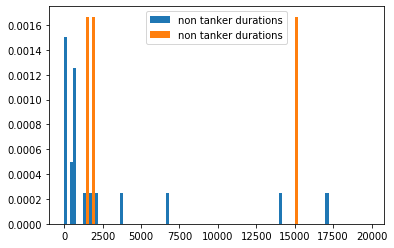

In [108]:
ports_lst = list(tankers_ports_set)
# curr_port = next(iter(tankers_ports_set))
curr_port = ports_lst[279]
curr_port_visits = train_set_df_orig[train_set_df_orig['port_id'] == curr_port]
curr_port_tanker_visits_durations = curr_port_visits[curr_port_visits['label']==1]['duration_min']
curr_port_non_tanker_visits_durations = curr_port_visits[curr_port_visits['label']==0]['duration_min']
print(f"There were {len(curr_port_tanker_visits_durations)} tankers visits and {len(curr_port_non_tanker_visits_durations)} non-tanker visits to port {curr_port}")
fig_visits, ax_visits = plt.subplots()
bins = np.arange(0,20000, 200)
ax_visits.hist(curr_port_non_tanker_visits_durations, bins=bins, density=True, label = "non tanker durations")
ax_visits.hist(curr_port_tanker_visits_durations,  bins=bins, density=True, label = "non tanker durations")
plt.legend()


**Durations distribution per vessel**

In [119]:
tanker_grouped = train_set_df_orig[train_set_df_orig['label']==1].groupby('ves_id')
tanker_grouped_iter = iter(tanker_grouped)
non_tanker_grouped = train_set_df_orig[train_set_df_orig['label']==0].groupby('ves_id')
non_tanker_grouped_iter = iter(non_tanker_grouped)

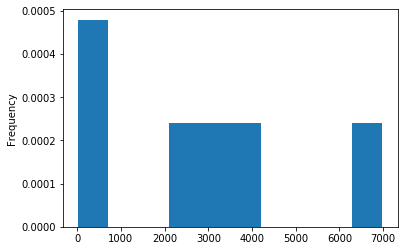

In [162]:
curr_tanker_df = next(tanker_grouped_iter)[1]
curr_tanker_df['duration_min'].plot.hist(density = True)

# non_tanker_grouped.get_group('56d8fabbe4b00724c0f7520b')['duration_min'].plot.hist()

In [178]:
curr_tanker_df['start_time']

144792   2016-04-01 15:55:48
144794   2016-02-17 10:04:13
144795   2016-03-17 05:20:43
144796   2016-04-01 05:31:17
144814   2016-04-09 12:35:47
148494   2016-04-02 12:54:49
Name: start_time, dtype: datetime64[ns]

In [181]:
curr_tanker_df['start_time'].max() - curr_tanker_df['start_time'].min()
# curr_tanker_df['start_time'].min()

Timedelta('52 days 02:31:34')

In [188]:
sorted_ts = curr_tanker_df['start_time'].sort_values()
deltas = sorted_ts[1:] - sorted_ts[:-1]

In [211]:
sorted_ts[1:]

144795   2016-03-17 05:20:43
144796   2016-04-01 05:31:17
144792   2016-04-01 15:55:48
148494   2016-04-02 12:54:49
144814   2016-04-09 12:35:47
Name: start_time, dtype: datetime64[ns]

In [210]:
(sorted_ts.iloc[1] - sorted_ts.iloc[0])#.astype('timedelta64[ns]')

Timedelta('28 days 19:16:30')

In [190]:
sorted_ts

144794   2016-02-17 10:04:13
144795   2016-03-17 05:20:43
144796   2016-04-01 05:31:17
144792   2016-04-01 15:55:48
148494   2016-04-02 12:54:49
144814   2016-04-09 12:35:47
Name: start_time, dtype: datetime64[ns]

In [209]:
deltas = sorted_ts.values[1:] - sorted_ts.values[:-1]
deltas[0].astype('timedelta64[D]')
deltas[0].astype('Timedelta')

TypeError: data type "Timedelta" not understood

In [226]:
tmp = [1,2,3]
tmp += ([4,5,6])
tmp

[1, 2, 3, 4, 5, 6]

**Durations distribution per class**

1070.0
498.0


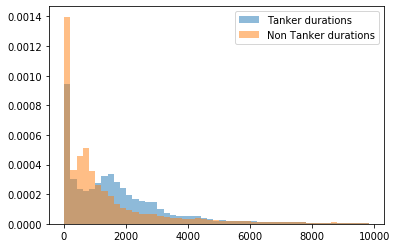

In [315]:
all_tanker_durations = train_set_df_orig[train_set_df_orig['label']==1]['duration_min']
all_non_tanker_durations = train_set_df_orig[train_set_df_orig['label']==0]['duration_min']
fig_durations,ax_durations = plt.subplots()
durations_bins = np.arange(10,10000, 200)
ax_durations.hist(all_tanker_durations, bins = durations_bins, density=True, label = 'Tanker durations', alpha=0.5)
ax_durations.hist(all_non_tanker_durations, bins = durations_bins, density=True, label = 'Non Tanker durations', alpha=0.5)
plt.legend()
print(np.median(all_tanker_durations.values))
print(np.median(all_non_tanker_durations.values))

**Num samples and overall series duration per vessel**

In [10]:
train_orig_grouped = train_set_df_orig.groupby('ves_id')


In [288]:
per_ves_ts_len_tanker = []
per_ves_ts_duration_tanker = []
overall_deltas_tanker = np.array([])
per_ves_ts_len_non_tanker = []
per_ves_ts_duration_non_tanker = []
overall_deltas_non_tanker = np.array([])

for vid, vdf in train_orig_grouped:
#     print(vid)
    is_tanker = vdf.iloc[0]['label'] == 1
    per_ves_ts_len  = per_ves_ts_len_tanker if is_tanker else per_ves_ts_len_non_tanker
    per_ves_ts_len.append(len(vdf))
    sorted_ts = vdf['start_time'].sort_values().values
    deltas = sorted_ts[1:] - sorted_ts[:-1]
    if is_tanker:
        overall_deltas_tanker = np.append(overall_deltas_tanker, deltas.astype('timedelta64[m]').astype('int'))
    else:
        overall_deltas_non_tanker = np.append(overall_deltas_non_tanker, deltas.astype('timedelta64[m]').astype('int'))
    per_ves_ts_duration = per_ves_ts_duration_tanker if is_tanker else per_ves_ts_duration_non_tanker
    per_ves_ts_duration.append(sorted_ts[-1]-sorted_ts[0])
    

In [289]:
overall_deltas_tanker

array([19337., 44039., 32045., ...,  2005.,  6043.,  6815.])

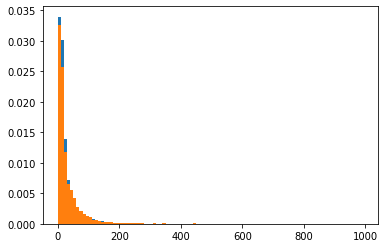

In [273]:
fig_ts_len, ax_ts_len = plt.subplots()
ax_ts_len.hist(per_ves_ts_len_tanker, bins=np.arange(0,1000,10), label='Tanker', density=True);
ax_ts_len.hist(per_ves_ts_len_non_tanker, bins=np.arange(0,1000,10), label='Non Tanker', density=True);

In [262]:
min(per_ves_ts_len)

1

In [249]:
np.array(per_ves_ts_duration).astype('timedelta64[m]').astype('int')

array([250356, 148235, 252381, ...,   1542,      0,      0])

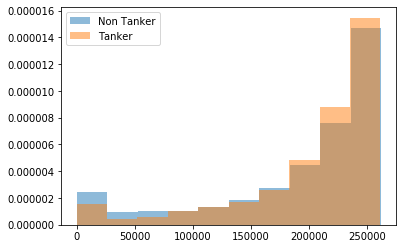

In [294]:
fig_ts_duration, ax_ts_duration = plt.subplots()
ax_ts_duration.hist(np.array(per_ves_ts_duration_non_tanker).astype('timedelta64[m]').astype('int'), label='Non Tanker', density=True, alpha=0.5);
ax_ts_duration.hist(np.array(per_ves_ts_duration_tanker).astype('timedelta64[m]').astype('int'), label='Tanker', density=True, alpha=0.5);

ax_ts_duration.legend()
# plt.hist(np.array(per_ves_ts_duration).astype('timedelta64[m]').astype('int'), density=True);

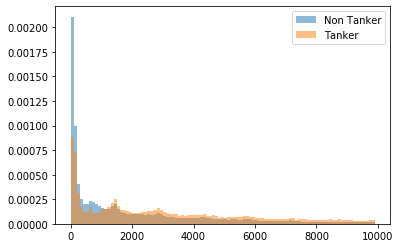

In [295]:
fig_ts_deltas, ax_ts_deltas = plt.subplots()
ax_ts_deltas.hist(overall_deltas_non_tanker,  label='Non Tanker', density=True, bins=np.arange(0,10000,100), alpha=0.5 ); 
ax_ts_deltas.hist(overall_deltas_tanker,  label='Tanker', density=True, bins=np.arange(0,10000,100), alpha=0.5 ); 
ax_ts_deltas.legend()

In [298]:
tanker_grouped_lst = list(tanker_grouped)
tanker_lst_lens = [len(vdf) for vid,vdf in tanker_grouped_lst]

In [302]:
np.argmax(tanker_lst_lens)

2741

In [300]:
len(tanker_lst_lens)

2898

In [313]:
# tanker_grouped_lst[2741][1].to_csv("tanker_2741.csv")
len(pd.unique(tanker_grouped_lst[2741][1]['port_id']))
curr_tanker_sorted_df = tanker_grouped_lst[2741][1].sort_values('start_time')
curr_tanker_sorted_df.to_csv("tanker_2741.csv")

In [316]:
non_tanker_grouped_lst = list(non_tanker_grouped)
non_tanker_lst_lens = [len(vdf) for vid,vdf in non_tanker_grouped_lst]

In [317]:
np.argmax(non_tanker_lst_lens)

9933

In [322]:
curr_non_tanker_sorted_df = non_tanker_grouped_lst[9933][1].sort_values('start_time')
curr_non_tanker_sorted_df.to_csv("non_tanker_9933.csv")

**Vess 56d96c11e4b0436ba6e245ca is a passenger vessel - it just travels between two ports: Cowes Harbour and southhampton**

In [24]:

vess_by_type = defaultdict(list)
for vid,vdf in train_orig_grouped:
    vess_by_type[vdf.iloc[0]['type']].append(vdf)



C:\Users\Matan\anaconda3\lib\site-packages\ipykernel_launcher.py:1: DeprecationWarning:

The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.

C:\Users\Matan\anaconda3\lib\site-packages\numpy\lib\histograms.py:908: RuntimeWarning:

invalid value encountered in true_divide



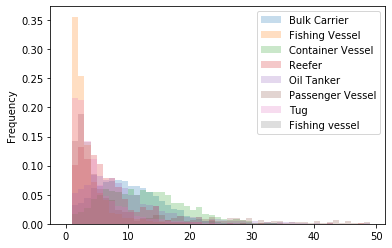

In [72]:
num_locations_per_type = { k : pd.Series( [len(np.unique(vdf['port_id'])) for vdf in vess_by_type[k]]) for k in vess_by_type}
pd.DataFrame(num_locations_per_type).plot.hist(alpha=0.25, density=True, bins=bins_for_num_locations)

In [47]:
non_tanker_num_locations = pd.Series(np.concatenate([loc_ser.values for k,loc_ser in  num_locations_per_type.items() if k != 'Oil Tanker' ]))

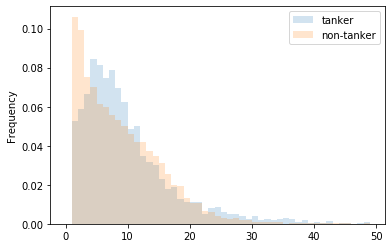

In [74]:
pd.DataFrame({"tanker": num_locations_per_type['Oil Tanker'],  "non-tanker": non_tanker_num_locations }).plot.\
hist(alpha=0.2, density=True, bins=bins_for_num_locations)

In [44]:
len(non_tanker_num_locations)

18224

In [54]:
len(non_tanker_num_locations.index.unique()) + len(num_locations_per_type['Oil Tanker'])

21122

In [53]:
sum([len(s) for s in num_locations_per_type.values() ])

21122

In [62]:
bins_for_num_locations = np.arange(0, 50, 1)

(array([0.        , 0.05248619, 0.05904696, 0.06664365, 0.08425414,
        0.08149171, 0.07458564, 0.07872928, 0.06975138, 0.0621547 ,
        0.04868785, 0.05006906, 0.03487569, 0.03176796, 0.03004144,
        0.02279006, 0.0179558 , 0.01864641, 0.01277624, 0.01104972,
        0.01139503, 0.01104972, 0.00483425, 0.00828729, 0.0086326 ,
        0.00587017, 0.00517956, 0.00517956, 0.00414365, 0.00241713,
        0.00414365, 0.00207182, 0.00241713, 0.00172652, 0.00241713,
        0.00310773, 0.00241713, 0.00069061, 0.00172652, 0.0003453 ,
        0.00069061, 0.0003453 , 0.00138122, 0.        , 0.0003453 ,
        0.0003453 , 0.        , 0.0003453 , 0.00069061]),
 array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
        34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49]),
 <a list of 49 Patch objects>)

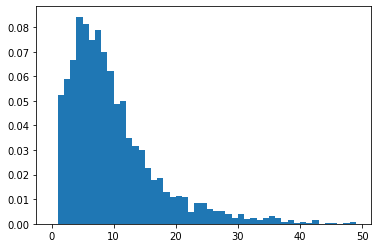

In [63]:
tanker_num_locations = [len(np.unique(vdf['port_id'])) for vdf in vess_by_type['Oil Tanker']]
plt.hist(tanker_num_locations, density=True, bins=bins_for_num_locations)

In [38]:
passengers_num_locations = [len(np.unique(vdf['port_id'])) for vdf in vess_by_type['Passenger Vessel']]

(array([0.        , 0.14226376, 0.18795431, 0.14018692, 0.08515057,
        0.06022845, 0.04465213, 0.04049844, 0.0238837 , 0.02076843,
        0.01973001, 0.00519211, 0.01038422, 0.00934579, 0.01557632,
        0.0145379 , 0.00726895, 0.01038422, 0.01349948, 0.00415369,
        0.00726895, 0.01142264, 0.00830737, 0.01142264, 0.00415369,
        0.00519211, 0.00934579, 0.00934579, 0.00623053, 0.00934579,
        0.00207684, 0.00623053, 0.00311526, 0.00519211, 0.00415369,
        0.00207684, 0.00311526, 0.00311526, 0.00311526, 0.00207684,
        0.00519211, 0.00207684, 0.00311526, 0.00623053, 0.00207684,
        0.00415369, 0.00103842, 0.00103842, 0.00311526]),
 array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
        34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49]),
 <a list of 49 Patch objects>)

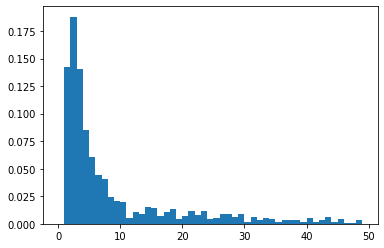

In [66]:
plt.hist(passengers_num_locations, bins=bins_for_num_locations, density=True)

(array([0.        , 0.21554661, 0.21275937, 0.14183958, 0.11117993,
        0.06720347, 0.0470734 , 0.03871168, 0.03065965, 0.02880149,
        0.01951068, 0.0142459 , 0.01238774, 0.00836172, 0.00867142,
        0.00836172, 0.00495509, 0.00495509, 0.00526479, 0.00371632,
        0.00309693, 0.00371632, 0.00185816, 0.00123877, 0.00123877,
        0.00030969, 0.00185816, 0.00061939, 0.        , 0.        ,
        0.        , 0.00030969, 0.00030969, 0.        , 0.00092908,
        0.        , 0.        , 0.        , 0.        , 0.00030969,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        ]),
 array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
        34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49]),
 <a list of 49 Patch objects>)

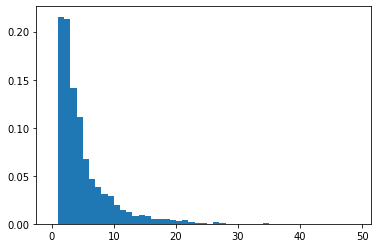

In [67]:
tug_num_locations = [len(np.unique(vdf['port_id'])) for vdf in vess_by_type['Tug']]
plt.hist(tug_num_locations, bins=bins_for_num_locations, density=True)

(array([0.        , 0.35604607, 0.25335893, 0.13627639, 0.07101727,
        0.05278311, 0.04174664, 0.01775432, 0.01727447, 0.01007678,
        0.01007678, 0.00767754, 0.00863724, 0.00479846, 0.00239923,
        0.00431862, 0.00191939, 0.00095969, 0.00143954, 0.00095969,
        0.        , 0.        , 0.        , 0.        , 0.00047985,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        ]),
 array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
        34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49]),
 <a list of 49 Patch objects>)

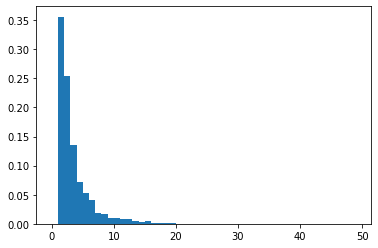

In [68]:
plt.hist([len(np.unique(vdf['port_id'])) for vdf in vess_by_type['Fishing Vessel']], density=True, bins=bins_for_num_locations)

(array([0.        , 0.03185407, 0.0358018 , 0.04424176, 0.06180234,
        0.06452491, 0.07160359, 0.07405391, 0.07582358, 0.07391778,
        0.0649333 , 0.06575007, 0.06084944, 0.05417915, 0.04696433,
        0.03906888, 0.0319902 , 0.02613667, 0.02382249, 0.01306834,
        0.01075415, 0.00748707, 0.00558127, 0.00435611, 0.00299483,
        0.00204193, 0.00108903, 0.00081677, 0.00081677, 0.00081677,
        0.00040839, 0.00040839, 0.00054451, 0.00054451, 0.00027226,
        0.        , 0.00013613, 0.00013613, 0.        , 0.00027226,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.00013613, 0.        , 0.        , 0.        ]),
 array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
        34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49]),
 <a list of 49 Patch objects>)

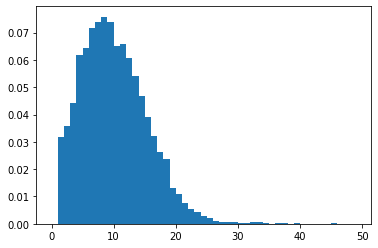

In [69]:
plt.hist([len(np.unique(vdf['port_id'])) for vdf in vess_by_type['Bulk Carrier']], density=True, bins=bins_for_num_locations)

(array([0.        , 0.01658826, 0.02005447, 0.02698688, 0.04184204,
        0.04976479, 0.05917306, 0.05644962, 0.05471651, 0.0514979 ,
        0.06016341, 0.04926962, 0.05793513, 0.05446893, 0.05471651,
        0.05545927, 0.04976479, 0.03490963, 0.03614756, 0.03119584,
        0.02352067, 0.02822481, 0.01634068, 0.01535033, 0.01089379,
        0.0089131 , 0.00569448, 0.00866551, 0.00668482, 0.00495172,
        0.00198069, 0.0017331 , 0.00123793, 0.0017331 , 0.0017331 ,
        0.        , 0.        , 0.        , 0.00049517, 0.00024759,
        0.        , 0.00024759, 0.        , 0.        , 0.00024759,
        0.        , 0.        , 0.        , 0.        ]),
 array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
        34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49]),
 <a list of 49 Patch objects>)

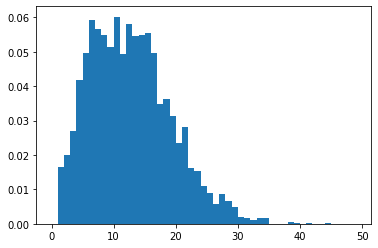

In [70]:
plt.hist([len(np.unique(vdf['port_id'])) for vdf in vess_by_type['Container Vessel']], density=True, bins=bins_for_num_locations)

In [13]:
np.unique(train_vessels_labels_orig.type)

array(['Bulk Carrier', 'Container Vessel', 'Fishing Vessel', 'Oil Tanker',
       'Passenger Vessel', 'Reefer', 'Tug'], dtype=object)

# Features engineering

In [14]:
#Plot a vessel timeseries
def plot_vessel_timeline(vessel_id, extracted_features = None, plot_ax = None):
    if plot_ax is None:
        fig_p, ax_p = plt.subplots()
    else:
        ax_p = plot_ax
    
    curr_patient_df = train_orig_grouped.get_group(vessel_id)
    first_timestamp = curr_patient_df['timestamp'].iloc[0]
    curr_patient_df.index = list(map(lambda ts : (ts -first_timestamp).total_seconds()*1000, curr_patient_df['timestamp']))
    curr_patient_df[['measurement_x', 'measurement_y', 'measurement_z']].plot(ax=ax_p)
    if extracted_features is not None:
        coefs = extracted_features[:9].reshape(3,3).T
        x_regr = curr_patient_df.index.values
        x_mat = np.array([np.ones(len(x_regr)), x_regr, x_regr*x_regr ]).T
        curr_patient_df_approx = pd.DataFrame( x_mat.dot(coefs), 
                                              columns = ['measurement_x_regr', 'measurement_y_regr', 'measurement_z_regr'], 
                                                index = curr_patient_df.index
                                             )
        curr_patient_df_approx[['measurement_x_regr', 'measurement_y_regr', 'measurement_z_regr']].plot(ax=ax_p, style='--')
    ax_p.set_title(f"Patient {patient_id} timeseries")
    ax_p.set_xlabel("time from first timestamp (ms)")
    return len(curr_patient_df), ax_p


In [15]:
def extract_time_series

#Converts the 
def extract_features(in_df: pd.DataFrame) -> pd.DataFrame:
    #TODO: input sanity checks   
    X = []
    y = []
    iter_over = in_dfs.groupby('patient_id') if type(in_dfs) ==  pd.DataFrame else in_dfs
    for _,patient_df in iter_over:
        extracted_features = extract_single_patient_features( patient_df, extraction_scheme, ts_handling_scheme, add_avg_dists )
     
#         print(f"Appending features of shape {extracted_features.shape}")
        X.append(extracted_features )
#         print(np.array(X).shape)
#         if len(X) == 388:
#             set_trace()
        if 'label' in patient_df:
            y.append(patient_df['label'].iloc[0])
    features_names = ['meas_{}_a{}'.format(i,j) for i in ['x', 'y', 'z'] for j in range(3)]
    intersection_names = ['intersect_x_y_1', 'intersect_x_y_2', 'intersect_x_z_1', 'intersect_x_z_2',  'intersect_y_z_1', 'intersect_y_z_2']
    avg_dist_names = ['avg_dist_x_y', 'avg_dist_x_z', 'avg_dist_y_z']
    
    all_features_names = features_names + intersection_names
    if add_avg_dists:
        all_features_names += avg_dist_names
    
    return np.array(X), np.array(y),  all_features_names

SyntaxError: invalid syntax (<ipython-input-15-eaa33083f872>, line 1)

# Some experiments #

In [16]:
import gmplot

# Create the map plotter:
apikey = '' # (your API key here)
gmap = gmplot.GoogleMapPlotter(37.766956, -122.448481, 14, apikey=apikey)

# Mark a hidden gem:
gmap.marker(37.770776, -122.461689, color='cornflowerblue')

# Highlight some attractions:
attractions_lats, attractions_lngs = zip(*[
    (37.769901, -122.498331),
    (37.768645, -122.475328),
    (37.771478, -122.468677),
    (37.769867, -122.466102),
    (37.767187, -122.467496),
    (37.770104, -122.470436)
])
gmap.scatter(attractions_lats, attractions_lngs, color='#3B0B39', size=40, marker=False)

# Outline the Golden Gate Park:
golden_gate_park = zip(*[
    (37.771269, -122.511015),
    (37.773495, -122.464830),
    (37.774797, -122.454538),
    (37.771988, -122.454018),
    (37.773646, -122.440979),
    (37.772742, -122.440797),
    (37.771096, -122.453889),
    (37.768669, -122.453518),
    (37.766227, -122.460213),
    (37.764028, -122.510347)
])
gmap.polygon(*golden_gate_park, color='cornflowerblue', edge_width=10)

# Draw the map to an HTML file:
gmap.draw('map.html')

In [17]:
import os
os.system('map.html')

0

TODO:
    * IMPORTANT!! Remove duplicates!!!
    * Distance and time gap between successive ports.
    * Has visited a single non-tanker port.
    * Typical duration distribution: per tanker, per port. percentiles of distribution as features.